# Creating cell aggregates

We want to create 500 cell aggreagates of 100 cells each. To create these groupings, we will randomly sample 500 cell from the latent space embedding. Using a nearest neighbor search we will then find the 100 nearest neighbors of these cells. Any group of cells which has an overlap >80% with any of the previously created groups will be removed. These cell aggregates can then be used for downstream correlation tasks.

In the following I subset all matrices (gene expression, ArchR gene scores computed from scATAC-seq and gene scores computed from peak-to-gene links to contain an overlapping list of genes. The reason why each matrix has a different number of genes is that ArchR gene scores contain more genes, because based on chromatin accessibility we might 

In [1]:
import scanpy as sc
import scvi
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from numba import jit, njit
import seaborn as sns
from scipy import sparse
import seaborn as sns
import pandas as pd
import h5py
import pickle
import csr

Global seed set to 0


#### Read in p2g activity scores

Several different ways to compute gene activity scores were tried over time, for example including negative peak-to-gene correlations vs. only positive correlations.
Using gene activity scores based on z-score peak-to-gene linkage matrix, in order to remove noise of peaks which are correlated with a lot of genes. This way, peaks which are only correlated with a few genes will have a higher z-score than peaks correlated with many genes. Another attempt to increase the  correlation of gene activity scores with gene expression was to use distance weight formulas as described in the ArchR gene activity score computation.

Additionally, here I only used highly variable genes, since genes which are not variable are not interesting to us and would introduce unnecessary noise.

In [26]:
matrix_dict = {}

In [87]:
debugging_adata = scvi.data.read_h5ad("p2g_gene_activity_scores/old_function_z_score")


In [88]:
debugging_adata.var = debugging_adata.var.rename(columns = {"rownames(scores)": "name"})
#debugging_adata = debugging_adata[:, debugging_adata.var.name.isin(weight_5k.var.name.tolist())]
debugging = debugging_adata.X
matrix_dict["old_function_z_score"] = debugging

In [93]:
# list of genes to use
test = debugging_adata.var.name.tolist()

In [41]:
import random

In [94]:
genes_to_use = random.sample(genes_to_use, len(genes_to_use))

In [95]:
[i for i, item in enumerate(test) if item == genes_to_use[i]]

[399, 1371]

In [7]:
#weight_5k = scvi.data.read_h5ad("p2g_gene_activity_scores/5000_distance_weighted_p2gfinal_scores")
#weight_50k = scvi.data.read_h5ad("p2g_gene_activity_scores/5e+05_distance_weighted_p2gfinal_scores")
#weight_500k = scvi.data.read_h5ad("p2g_gene_activity_scores/5e+06_distance_weighted_p2gfinal_scores")
#weight_5000k = scvi.data.read_h5ad("p2g_gene_activity_scores/5e+07_distance_weighted_p2gfinal_scores")

In [8]:
#for name, anndata in {"dist_weight_5k":weight_5k, "dist_weight_50k":weight_50k,"dist_weight_500k": weight_500k, "dist_weight_5000k":weight_5000k}.items():
    # rename column
 #   anndata.var = anndata.var.rename(columns = {"rownames(weighted_scores)":"name"})
  #  anndata = anndata[:, anndata.var.name.isin(genes_to_use)]
   # matrix_dict[name] = anndata.X

Z-scores over all genes for each peak of peak-to-gene link matrix to compute gene activity scores.

In [9]:
#p2g_z_scores_adata = scvi.data.read_h5ad("p2g_gene_activity_scores/z_score_p2g_gene_activity_scores")
#p2g_z_scores_adata.var = p2g_z_scores_adata.var.rename(columns = {"rownames(scores)": "name"})
#p2g_z_scores_adata = p2g_z_scores_adata[:, p2g_z_scores_adata.var.name.isin(genes_to_use)]
#p2g_z_scores = p2g_z_scores_adata.X

In [10]:
#matrix_dict["positive p2g links & z-scores"] = p2g_z_scores

Instead of using the constant of total activity across all cells for the size factors in our gene activity score computation based on peak-to-gene links, I just divided by the expected total activity given a certain library size (output of the linear regression). See function for computing gene activity score from peak-to-gene links in R. If we compare the plots between using two different functions, the result is almost the same, so the constant does not seem to make a difference.

In [11]:
#p2g_scores_adata =scvi.data.read_h5ad("p2g_gene_activity_scores/p2g_scores_anndata.h5ad")

In [12]:
#matrix_dict["positive & negative p2g links"] = p2g_scores

In [13]:
#pos_p2g_scores_adata = scvi.data.read_h5ad("p2g_gene_activity_scores/pos_p2g_links_scores")
#pos_p2g_scores_adata.var = pos_p2g_scores_adata.var.rename(columns = {"rownames(scores)": "name"})
#pos_p2g_scores_adata = pos_p2g_scores_adata[:, pos_p2g_scores_adata.var.name.isin(genes_to_use)]
#pos_p2g_scores = pos_p2g_scores_adata.X
#matrix_dict["positive p2g links"] = pos_p2g_scores

In [14]:
# read in overlapping gene names
#gene_names = pd.read_pickle(r"gene_names.pkl")

In [78]:
scores_adata = scvi.data.read_h5ad("p2g_gene_activity_scores/archr_gene_scores")
scores_adata.var_names = scores_adata.var.name
#scores_adata = scores_adata[:, scores_adata.var.name.isin(genes_to_use)]
scores_adata = scores_adata[:, genes_to_use]

/omics/groups/OE0533/internal/katharina/scvi2/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [79]:
(np.where(scores_adata.var["name"] != genes_to_use))[0].shape

(0,)

In [80]:
scores = scores_adata.X
matrix_dict["ArchR scores"] = scores

#### Read in latent space and gene expression matrix

In [81]:
# read in the anndata object which contains the latent space embedding
adata = scvi.data.read_h5ad("gpu_trained_20_dim/anndata_object")

# read the anndata object containing ArchR gene expression matrix
archr_gene_expr = scvi.data.read_h5ad("p2g_gene_activity_scores/ArchR_gene_expr.h5ad")

In [108]:
archr_gene_expr.var_names = archr_gene_expr.var.name
archr_gene_expr = archr_gene_expr[:, test]
gene_expr = archr_gene_expr.X
matrix_dict["gene_expr"] = gene_expr

In [83]:
np.where(archr_gene_expr.var["name"] != genes_to_use)

(array([], dtype=int64),)

In [84]:
np.where(archr_gene_expr.obs.index != debugging_adata.obs.index)

(array([], dtype=int64),)

In [109]:
[i for i, item in enumerate(archr_gene_expr.var["name"]) if item == scores_adata.var["name"][i]]

[507, 858, 1441]

In [107]:
[i for i, item in enumerate(archr_gene_expr.obs.index.tolist()) if item != debugging_adata.obs.index.tolist()[i]]

[]

In [85]:
# subset anndata object to contain only overlapping cells
adata = adata[archr_gene_expr.obs.index, :]

# get latent space embedding
latent_embedding = adata.obsm["X_scVI"]

In [114]:
latent_embedding.shape

(45986, 20)

archr_scores_peak_based_adata = scvi.data.read_h5ad("p2g_gene_activity_scores/archr_scores_peak_based")
#archr_scores_peak_based_adata.var = archr_scores_peak_based_adata.var.rename(columns = {"rownames(scores_mat)": "name"})

archr_scores_peak_based_adata = archr_scores_peak_based_adata[:, archr_scores_peak_based_adata.var.name.isin(genes_to_use)]
archr_scores_peak_based = archr_scores_peak_based_adata.X
matrix_dict["archr_scores_peak_based"] = archr_scores_peak_based

archr_scores_tss_adata = scvi.data.read_h5ad("p2g_gene_activity_scores/archr_scores_tss")
archr_scores_tss_adata = archr_scores_tss_adata[:, archr_scores_tss_adata.var.name.isin(genes_to_use)]
archr_scores_tss = archr_scores_tss_adata.X
matrix_dict["archr_scores_tss"] = archr_scores_tss

archr_scores_gene_body_peak_based = scvi.data.read_h5ad("p2g_gene_activity_scores/archr_scores_gene_body_peak_based")
archr_scores_gene_body_peak_based = archr_scores_gene_body_peak_based[:, archr_scores_gene_body_peak_based.var.name.isin(genes_to_use)]
archr_scores_gene_body_peak_based = archr_scores_gene_body_peak_based.X
matrix_dict["archr_scores_gene_body_peak_based"] = archr_scores_gene_body_peak_based

In [65]:
gene_window_scores_adata = scvi.data.read_h5ad("p2g_gene_activity_scores/gene_window_scoresgene_window_scores")

In [ ]:
gene_window_scores_adata.var = gene_window_scores_adata.var.rename(columns = {"rownames(weighted_scores)": "name"})
gene_window_scores_adata.var_names = gene_window_scores_adata.var.name
gene_window_scores_adata = gene_window_scores_adata[:, genes_to_use]
gene_window_scores = gene_window_scores_adata.X
matrix_dict["gene_window_scores"] = gene_window_scores

In [ ]:
debugging_adata = scvi.data.read_h5ad("p2g_gene_activity_scores/debugging7")
debugging_adata.var = debugging_adata.var.rename(columns = {"rownames(scores)": "name"})
debugging_adata.var_names = debugging_adata.var.name
debugging_adata = debugging_adata[:, genes_to_use]
debugging = debugging_adata.X
matrix_dict["debugging7"] = debugging

In [110]:
matrix_dict

{'debugging': array([[0.0004124 , 0.00040753, 0.00047194, ..., 0.00054847, 0.00062301,
         0.00064104],
        [0.00058506, 0.00043459, 0.00069861, ..., 0.00066941, 0.00063604,
         0.00065959],
        [0.00031097, 0.00032766, 0.00026892, ..., 0.00053539, 0.00068289,
         0.000505  ],
        ...,
        [0.00010145, 0.        , 0.00029581, ..., 0.00014179, 0.00103783,
         0.00030939],
        [0.00063565, 0.00015488, 0.00070058, ..., 0.00046892, 0.00014166,
         0.00013282],
        [0.00052051, 0.        , 0.00031847, ..., 0.00051315, 0.0003666 ,
         0.0015319 ]], dtype=float32),
 'ArchR scores': ArrayView([[0.507, 0.505, 0.897, ..., 0.701, 1.734, 0.194],
            [1.228, 0.056, 2.985, ..., 0.209, 1.667, 0.202],
            [1.064, 0.518, 0.639, ..., 0.189, 0.436, 0.091],
            ...,
            [0.   , 2.786, 0.   , ..., 0.   , 2.815, 0.   ],
            [0.   , 0.   , 0.   , ..., 3.363, 3.898, 0.   ],
            [0.   , 0.   , 0.   , ..., 0.  

### Sample cells & compute nearest neighbors

Since we have 45,991 cells in our dataset, we will sample 1000 cell aggregates of 50 cells each. 

In [17]:
class nearest_neighbors:
    def __init__(self, latent_embedding):
    # attribute root of the class Tree will be an instance of the class Node
    # attriute self.root is an object of class Node
        self.latent_embedding = latent_embedding
        
    def sampling_cells(self, n_aggregates):
        self.sample_cells = np.random.choice(self.latent_embedding.shape[0], n_aggregates, replace=False)
        #print(self.sample_cells.shape)
        assert self.sample_cells.shape[0] == n_aggregates,"sample cells vector has incorrect length."
    
    def compute_NN(self, k):
        print(f"Computing {k} nearest neighbors for {self.sample_cells.shape[0]} cells.")
        nbrs = NearestNeighbors(n_neighbors=k, algorithm="ball_tree").fit(self.latent_embedding)
        dist, ind = nbrs.kneighbors(self.latent_embedding)
        assert dist.shape[0] == self.latent_embedding.shape[0], "wrong dimensions of neigbor search"
        # subset the nearest neighbors to only contain the sampled cells
        self.distance = dist[self.sample_cells, :]
        self.index = ind[self.sample_cells, :]
        # The index matrix should now contain the number of cells as nrows and k cols
        assert self.index.shape[0] == self.sample_cells.shape[0], "wrong dimensions in nearest neighbor index matrix"
        assert self.index.shape[1] == k, "wrong dimensions of nearest neighbor index matrix"

    

### Check for overlapping cell aggregates

In [18]:
# We want to check whether the 50 nearest neighbors of any given cell overlap with the 50 nearest neighbors of any other cell by more than 80%
@jit(nopython=True)
def check_overlap(index, sample_cells):
    nrow = index.shape[0] # number of cells
    ncol = index.shape[1] # number of neighbors 
    # create an array to store whether a cell passed the overlap check
    # all entries are initially False
    considered_cells = np.zeros(nrow).astype(np.bool8)
    # loop over each cell and cosider to add it to the set of cell aggregates
    for i in range(nrow):
        check = True
        # loop over all previous aggregates 
        for comp in np.where(considered_cells)[0]:
            # get the number of cells which overlap between the neighborhood of the cell we would like to add and the neighborhoud of previous cell "comp"
            intersect = np.intersect1d(index[i, :], index[comp, :])
            # for each comparison between current cell i which we would like to add and previous cell which we are comparing to
            # compute the percentage of overlap
            if (len(intersect) / ncol) > 0.8: # if the intersection is above 0.8, we do not consider it
                check = False
                break
        if check:
            considered_cells[i] = True
    # get indices
    keep = np.arange(start=0, stop=nrow, step=1)[considered_cells]
    print(f"Of {nrow} cell aggregates we keep {index[keep, :].shape[0]} cells.")
    return index[keep, :], sample_cells[keep]
    

### Only keep cells of same celltype

In [19]:
# We only want to keep cells of the same celltype
def filter_celltypes(metadata, sample_cells_keep, idx_keep):
    groups={}
    celltypes = []
    # check whether a cell aggregate contains cells of other celltypes and remove then
    for n, i in enumerate(sample_cells_keep):
        # check that the index in the sample cells is equivalent to the one in the nearest neighbor index matrix
        assert (sample_cells_keep==idx_keep[:, 0]).all()
        # get celltype information of sampled cell
        celltype_test_cell = metadata.iloc[i]["celltype"]
        # get indices of cells which are in the neighborhood 
        neighbor_cells = idx_keep[n, :]
        assert neighbor_cells.shape[0] == idx_keep.shape[1]
        # get cells which are of the same celltype, vector includes the sampled cell itself
        keep = np.array(metadata[(metadata.idx.isin(neighbor_cells.flatten())) & (metadata.celltype == celltype_test_cell)]["idx"])
        # keep only aggregates which contain at least 10 cells after removing non-matching celltypes
        if keep.shape[0] > 10:
            groups[i] = keep
            celltypes.append(celltype_test_cell)
        else:
            continue
    print(f"Out of {len(sample_cells_keep)} cell aggregates which passed the overlap check we are left with {len(groups)} after checking for celltype consistency")
    # add dictionary to self
    return groups, celltypes

## Aggregate expression/scores/accessibility 

TODO: Implement aggregation with numba -> convert to csr matrx

https://numba.pydata.org/numba-doc/0.43.0/reference/pysupported.html

In [20]:
def create_aggregates(mat, groups): # the matrix should have dimensions cells x genes
    # initialize matrix to store average gene expression for each cell aggregate
    # the matrix has dimensions genes x cell aggregates
    rna_agg = np.zeros((mat.shape[1],len(groups)))
    # for each cell aggregate calculate the average gene expression for each gene
    for i, g in enumerate(groups):
        rna_agg[:, i] = mat[groups[g], :].mean(axis=0)
        assert (rna_agg[:, i] == mat[groups[g], :].mean(axis=0)).all(), "Dimension mismatch"
    print(f"The aggregate matrix has dimensions: {rna_agg.shape}")
    rna_agg =  sparse.csr_matrix(rna_agg)
    return csr.CSR.from_scipy(rna_agg)#, rna_agg # the first is a csr.csr.CSR matrix, the second one is a scipy.sparse.csr.csr_matrix

# Correlations

To compute row-wise correlations:

In [21]:
@jit(nopython=True)
def rowwise_correlation(A, B):
    correlations = []
    for i in range(A.nrows):
        # center and scale row i of matrix A
        rowa = A.row(i)
        rowa -= np.mean(rowa)
        rowa /= np.std(rowa)
        
        # center and scale row i of matrix B
        rowb = B.row(i)
        rowb -= np.mean(rowb)
        rowb /= np.std(rowb)
        
        # compute correlation between row i of matrix A and B
        corr = np.mean(rowa*rowb)
        correlations.append(corr)
    return correlations

## Function to automate all computatiosn for different matrices

In [22]:
def score_correlations(latent_space_adata, latent_embedding, n_aggregates, k, gene_expr, matrix_dict):
    agg_object = nearest_neighbors(latent_embedding) # initialize the cell aggreagte object
    agg_object.sampling_cells(n_aggregates) # sample cells
    agg_object.compute_NN(k) # compute nearest neighbors 
    idx_keep, sample_cells_keep = check_overlap(agg_object.index, agg_object.sample_cells) # remove overlapping cells
    metadata = latent_space_adata.obs
    # create column for cell names
    metadata["cells"] = metadata.index
    # create index for cells
    metadata["idx"] = np.arange(len(metadata))
    groups, celltype_list = filter_celltypes(metadata, sample_cells_keep, idx_keep)
    
    # aggregate gene expression
    rna_agg = create_aggregates(gene_expr, groups)
    
    # aggregate gene activity score matrices stored in the matrix_dictionary
    # create empty list to store aggregate matrices
    agg_corr = {}
    for name, matrix in matrix_dict.items():
        #if name != gene_expr:
        agg = create_aggregates(matrix, groups)
        print(type(agg))
        corr = rowwise_correlation(rna_agg, agg)
        agg_corr[name] = (agg, corr)
        sns.histplot(corr, bins = 200)
        plt.axvline(0, color = "red")
        plt.title(f"Correlation between gene expr. and {name}.")
        plt.show()
        
    return(agg_corr)

Computing 50 nearest neighbors for 1000 cells.
Of 1000 cell aggregates we keep 994 cells.
Out of 994 cell aggregates which passed the overlap check we are left with 936 after checking for celltype consistency
The aggregate matrix has dimensions: (1706, 936)
The aggregate matrix has dimensions: (1706, 936)
<class 'csr.csr.CSR'>


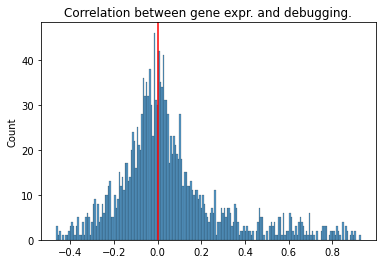

The aggregate matrix has dimensions: (1706, 936)
<class 'csr.csr.CSR'>


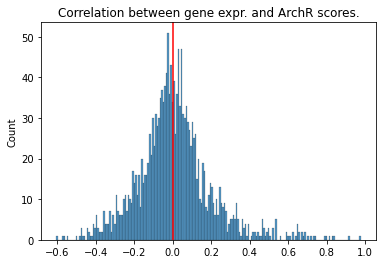

The aggregate matrix has dimensions: (1706, 936)
<class 'csr.csr.CSR'>


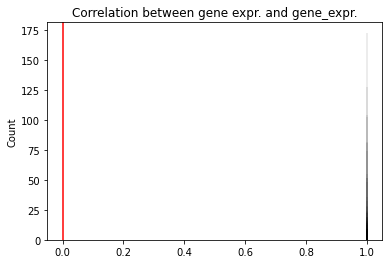

The aggregate matrix has dimensions: (1706, 936)
<class 'csr.csr.CSR'>


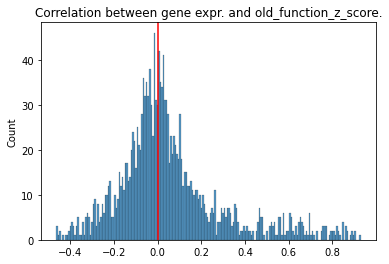

In [111]:
corr_vectors = score_correlations(adata, latent_embedding, 1000, 50, gene_expr, matrix_dict)

In [83]:
def plot_correlations(corr_vectors):
    archr_scores = corr_vectors["ArchR scores"][1]
    # set color palette for density plot
    cmap = sns.color_palette("viridis", as_cmap=True)
    for name, vector in corr_vectors.items():
        if name != "gene_expr" and name != "ArchR scores":
        # create scatterplot
            sns.scatterplot(x=np.asarray(vector[1]), y=np.asarray(archr_scores), color="k")
            # add density plot on top
            sns.kdeplot(x=np.asarray(vector[1]), y=np.asarray(archr_scores), 
                       levels=6, fill=True, alpha=0.7, cut=2, cmap=cmap)
            plt.plot(np.linspace(-0.2, 1, 100), np.linspace(-0.2, 1, 100) , color='r')
            plt.xlabel(f"correlation between gene expr. and {name}")
            plt.ylabel("Correlation between gene expr. and ArchR scores")
            plt.title(f"Comparing correlation values for {len(archr_scores)} most highly variable genes")
            plt.axvline(0, color="black")
            plt.axhline(0, color="black")
            plt.show()

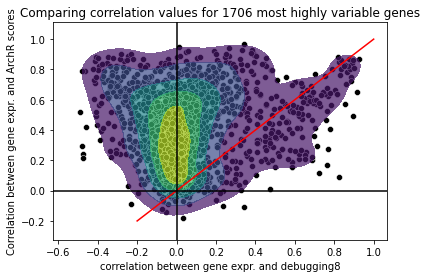

In [84]:
plot_correlations(corr_vectors)

In [ ]:
corr_vectors
sns.scatterplot(x=np.asarray(vector[1]), y=np.asarray(archr_scores), color="k")
# add density plot on top
sns.kdeplot(x=np.asarray(vector[1]), y=np.asarray(archr_scores), 
           levels=6, fill=True, alpha=0.7, cut=2, cmap=cmap)
plt.plot(np.linspace(-0.2, 1, 100), np.linspace(-0.2, 1, 100) , color='r')
plt.xlabel(f"correlation between gene expr. and {name}")
plt.ylabel("Correlation between gene expr. and ArchR scores")
plt.title(f"Comparing correlation values for {len(archr_scores)} most highly variable genes")
plt.axvline(0, color="black")
plt.axhline(0, color="black")
plt.show()

#### Prepare the metadata for the cell aggregate function:

In [ ]:
metadata = adata.obs
# create column for cell names
metadata["cells"] = metadata.index
# create index for cells
metadata["idx"] = np.arange(len(metadata))

https://stackoverflow.com/questions/20928136/input-and-output-numpy-arrays-to-h5py

### Sample cells & compute nearest neighbors

Since we have 45,991 cells in our dataset, we will sample 1000 cell aggregates of 50 cells each. 

In [ ]:
class nearest_neighbors:
    def __init__(self, latent_embedding):
    # attribute root of the class Tree will be an instance of the class Node
    # attriute self.root is an object of class Node
        self.latent_embedding = latent_embedding
        
    def sampling_cells(self, n_aggregates):
        self.sample_cells = np.random.choice(self.latent_embedding.shape[0], n_aggregates, replace=False)
        #print(self.sample_cells.shape)
        assert self.sample_cells.shape[0] == n_aggregates,"sample cells vector has incorrect length."
    
    def compute_NN(self, k):
        print(f"Computing {k} nearest neighbors for {self.sample_cells.shape[0]} cells.")
        nbrs = NearestNeighbors(n_neighbors=k, algorithm="ball_tree").fit(self.latent_embedding)
        dist, ind = nbrs.kneighbors(self.latent_embedding)
        assert dist.shape[0] == self.latent_embedding.shape[0], "wrong dimensions of neigbor search"
        # subset the nearest neighbors to only contain the sampled cells
        self.distance = dist[self.sample_cells, :]
        self.index = ind[self.sample_cells, :]
        # The index matrix should now contain the number of cells as nrows and k cols
        assert self.index.shape[0] == self.sample_cells.shape[0], "wrong dimensions in nearest neighbor index matrix"
        assert self.index.shape[1] == k, "wrong dimensions of nearest neighbor index matrix"

    

### Check for overlapping cell aggregates

In [ ]:
# We want to check whether the 50 nearest neighbors of any given cell overlap with the 50 nearest neighbors of any other cell by more than 80%
@jit(nopython=True)
def check_overlap(index, sample_cells):
    nrow = index.shape[0] # number of cells
    ncol = index.shape[1] # number of neighbors 
    # create an array to store whether a cell passed the overlap check
    # all entries are initially False
    considered_cells = np.zeros(nrow).astype(np.bool8)
    # loop over each cell and cosider to add it to the set of cell aggregates
    for i in range(nrow):
        check = True
        # loop over all previous aggregates 
        for comp in np.where(considered_cells)[0]:
            # get the number of cells which overlap between the neighborhood of the cell we would like to add and the neighborhoud of previous cell "comp"
            intersect = np.intersect1d(index[i, :], index[comp, :])
            # for each comparison between current cell i which we would like to add and previous cell which we are comparing to
            # compute the percentage of overlap
            if (len(intersect) / ncol) > 0.8: # if the intersection is above 0.8, we do not consider it
                check = False
                break
        if check:
            considered_cells[i] = True
    # get indices
    keep = np.arange(start=0, stop=nrow, step=1)[considered_cells]
    print(f"Of {nrow} cell aggregates we keep {index[keep, :].shape[0]} cells.")
    return index[keep, :], sample_cells[keep]
    

### Only keep cells of same celltype

In [ ]:
# We only want to keep cells of the same celltype
def filter_celltypes(metadata, sample_cells_keep, idx_keep):
    groups={}
    celltypes = []
    # check whether a cell aggregate contains cells of other celltypes and remove then
    for n, i in enumerate(sample_cells_keep):
        # check that the index in the sample cells is equivalent to the one in the nearest neighbor index matrix
        assert (sample_cells_keep==idx_keep[:, 0]).all()
        # get celltype information of sampled cell
        celltype_test_cell = metadata.iloc[i]["celltype"]
        # get indices of cells which are in the neighborhood 
        neighbor_cells = idx_keep[n, :]
        assert neighbor_cells.shape[0] == idx_keep.shape[1]
        # get cells which are of the same celltype, vector includes the sampled cell itself
        keep = np.array(metadata[(metadata.idx.isin(neighbor_cells.flatten())) & (metadata.celltype == celltype_test_cell)]["idx"])
        # keep only aggregates which contain at least 10 cells after removing non-matching celltypes
        if keep.shape[0] > 10:
            groups[i] = keep
            celltypes.append(celltype_test_cell)
        else:
            continue
    print(f"Out of {len(sample_cells_keep)} cell aggregates which passed the overlap check we are left with {len(groups)} after checking for celltype consistency")
    # add dictionary to self
    return groups, celltypes

#### Apply functions to our data

In [ ]:
agg_object = nearest_neighbors(latent_embedding) # initialize the cell aggreagte object
agg_object.sampling_cells(n_aggregates=1000) # sample cells
agg_object.compute_NN(k=50) # compute nearest neighbors 
idx_keep, sample_cells_keep = check_overlap(agg_object.index, agg_object.sample_cells) # remove overlapping cells

In [ ]:
metadata = adata.obs
# create column for cell names
metadata["cells"] = metadata.index
# create index for cells
metadata["idx"] = np.arange(len(metadata))

## Aggregate expression/scores/accessibility 

TODO: Implement aggregation with numba -> convert to csr matrx

https://numba.pydata.org/numba-doc/0.43.0/reference/pysupported.html

In [ ]:
def create_aggregates(mat, groups): # the matrix should have dimensions cells x genes
    # initialize matrix to store average gene expression for each cell aggregate
    # the matrix has dimensions genes x cell aggregates
    rna_agg = np.zeros((mat.shape[1],len(groups)))
    # for each cell aggregate calculate the average gene expression for each gene
    for i, g in enumerate(groups):
        rna_agg[:, i] = mat[groups[g], :].mean(axis=0)
        assert (rna_agg[:, i] == mat[groups[g], :].mean(axis=0)).all(), "Dimension mismatch"
    print(f"The aggregate matrix has dimensions: {rna_agg.shape}")
    rna_agg =  sparse.csr_matrix(rna_agg)
    return csr.CSR.from_scipy(rna_agg)#, rna_agg # the first is a csr.csr.CSR matrix, the second one is a scipy.sparse.csr.csr_matrix

#### Aggregate Gene expression

In [ ]:
# create gene expression aggregates 
rna_agg = create_aggregates(gene_expr, groups)

#### Aggregate Gene Scores from ArchR

In [ ]:
# gene scores
score_agg = create_aggregates(scores, groups)

#### Gene Scores from p2g links

In [ ]:
# the first version of the formula

In [ ]:
# the formula with distance weight
weighted_agg = create_aggregates(weighted_scores, groups)

In [ ]:
# the formula with z-scores & constant
scores_p2g_z_agg = create_aggregates(p2g_z_scores, groups)

In [ ]:
# the formula with z-score & without constant
#p2g_noconstant_agg, sparse_p2g_noconstant_agg = create_aggregates(p2g_scores_noconstant, groups)

In [ ]:
# the formula with raw p2g links & constant
#p2g_hvg_agg, sparse_p2g_hvg_agg = create_aggregates(p2g_scores_hvg, groups)

# Correlations

To compute row-wise correlations:

In [ ]:
@jit(nopython=True)
def rowwise_correlation(A, B):
    correlations = []
    for i in range(A.nrows):
        # center and scale row i of matrix A
        rowa = A.row(i)
        rowa -= np.mean(rowa)
        rowa /= np.std(rowa)
        
        # center and scale row i of matrix B
        rowb = B.row(i)
        rowb -= np.mean(rowb)
        rowb /= np.std(rowb)
        
        # compute correlation between row i of matrix A and B
        corr = np.mean(rowa*rowb)
        correlations.append(corr)
    return correlations

In [ ]:
# correlation across cell aggregates
corr_expr_scores = rowwise_correlation(rna_agg, score_agg)

In [ ]:
sns.histplot(corr_expr_scores, bins=200)
plt.axvline(0, color ="red") 
plt.title("Correlation betwen gene expression and ArchR gene scores")

In [ ]:
corr_expr_p2g_scores = rowwise_correlation(rna_agg, scores_p2g_z_agg)

In [ ]:
sns.histplot(corr_expr_p2g_scores, bins=200)
plt.axvline(0, color="red")
plt.title("Correlations between gene expression and p2g link scores (z_scores) across cell aggregates")

In [ ]:
corr_weighted_scores = rowwise_correlation(rna_agg, weighted_agg)

In [ ]:
sns.histplot(corr_weighted_scores, bins=200)
plt.axvline(0, color="red")
plt.title("Correlations between gene expression and distance-weighted p2g link scores across cell aggregates")

In [ ]:
# set color palette for density plot
cmap = sns.color_palette("viridis", as_cmap=True)

# create scatterplot
sns.scatterplot(x=np.asarray(corr_expr_p2g_scores), y=np.asarray(corr_expr_scores),
               color="k")
# add density plot on top
sns.kdeplot(x=np.asarray(corr_expr_p2g_scores), y=np.asarray(corr_expr_scores), 
           levels=6, fill=True, alpha=0.7, cut=2, cmap=cmap)
plt.plot(np.linspace(-0.2, 1, 100), np.linspace(-0.2, 1, 100) , color='r')
plt.xlabel("correlation between gene expr. and p2g scores")
plt.ylabel("Correlation between gene expr. and ArchR scores")
plt.title(f"Comparing correlation values for {gene_expr.shape[1]} most highly variable genes")
plt.axvline(0, color="black")
plt.axhline(0, color="black")

In [ ]:
# set color palette for density plot
cmap = sns.color_palette("viridis", as_cmap=True)

# create scatterplot
sns.scatterplot(x=np.asarray(corr_weighted_scores), y=np.asarray(corr_expr_scores),
               color="k")
# add density plot on top
sns.kdeplot(x=np.asarray(corr_weighted_scores), y=np.asarray(corr_expr_scores), 
           levels=6, fill=True, alpha=0.7, cut=2, cmap=cmap)
plt.plot(np.linspace(-0.2, 1, 100), np.linspace(-0.2, 1, 100) , color='r')
plt.xlabel("correlation gene expr. and distance-weighted p2g scores")
plt.ylabel("Correlation  gene expr. and ArchR scores")
plt.title(f"Comparing correlation values for {gene_expr.shape[1]} most highly variable genes")
plt.axvline(0, color="black")
plt.axhline(0, color="black")

In [ ]:
corr_expr_p2g_no_constant = rowwise_correlation(rna_agg, p2g_noconstant_agg)

In [ ]:
sns.histplot(corr_expr_p2g_no_constant, bins=200)
plt.axvline(0, color="red")
plt.title("Correlations between gene expression and p2g link scores (no constant in formula) across cell aggregates")

In [ ]:
corr_hvg = rowwise_correlation(rna_agg, p2g_hvg_agg)

In [ ]:
sns.histplot(corr_hvg, bins=200)
plt.axvline(0, color="red")
plt.title("Correlations between gene expression and p2g link scores (no z-scores) across cell aggregates")

In [ ]:
corr_scores = rowwise_correlation(scores_p2g_agg, score_agg)

In [ ]:
sns.histplot(corr_scores, bins=200)
plt.axvline(0, color="red")
plt.title("Correlation between ArchR gene score and p2g scores")

In [ ]:
sns.scatterplot(np.asarray(corr_expr_p2g_scores), y = np.asarray(corr_expr_scores))
plt.xlabel("correlation between gene expr. and p2g scores")
plt.ylabel("Correlation between gene expr. and ArchR scores")
plt.title("Comparing correlation values for {hvg_index.shape[0]} most highly variable genes")
plt.axvline(0, color="red")
plt.axhline(0, color="red")

#### Check the genes which have negative correlations.

In [ ]:
#gene_names_index = [i for i in range(0, len(gene_names))]


In [ ]:
# lets check highly variable genes
df = pd.read_csv('hvg_list', delimiter=',')

In [ ]:
hvg_list = df["x"].tolist()

In [ ]:
hvg_index = np.where(np.isin(hvg_list, gene_names))[0]
print(f"There are {len(hvg_list)} highly variable genes identified, out of which {hvg_index.shape[0]} are found in our genes x cell aggregates matrix")

In [ ]:
marker_genes_idx = np.where(np.isin(gene_names, ["Lamb1",  "Sparc", "Elf5", "Ascl2", "Tfap2c", "Ttr", \
                  "Apoa2", "Apoe", "Cystm1", "Emb", "Spink1",  "Krt19", \
                  "Dkk1", "Grhl3", "Trp63", "Grhl2",  "Pax6", "Pax2", \
                  "En1", "Foxd3", "Tfap2a", "Pax3", "Sox9", \
                  "Six3", "Hesx1", "Irx3", "Sox2", "Hoxb9", "Cdx4",\
                  "Hes3", "Hba-a2", "Hba-a1",  "Hbb-bh1", "Gata1", "Cited4", \
                  "Cdh5", "Pecam1", "Anxa5", "Etv2", "Igf2",\
                  "Krt8", "Krt18", "Pmp22", "Ahnak", "Bmp4", "Tbx4", "Hoxa11", \
                  "Hoxa10", "Tnnt2", "Myl4",  "Myl7", "Acta2",  \
                  "Smarcd3", "Tcf21", "Tbx6", "Dll1", "Aldh1a2", "Tcf15", \
                  "Meox1", "Tbx1", "Gbx2", "Cdx1", "Hoxb1", "Hes7", "Osr1", \
                  "Mesp2", "Lefty2", "Mesp1", "Cer1",  "Chrd", "T", \
                  "Foxa2", "Pax7", "Fgf8", "Lhx1", "Gsc", "Mixl1", "Otx2", "Hhex",\
                  "Ifitm3", "Nkx1-2", "Eomes", "Nanog", "Utf1", \
                  "Epcam", "Pou5f1"]))[[0]]

In [ ]:
sns.histplot(np.asarray(corr_expr_p2g_scores)[hvg_index], bins = 200)
plt.axvline(color="red")
plt.title(f"Correlations between gene expression and peak-to-gene linkage gene scores for {hvg_index.shape[0]} highly variable genes")

In [ ]:
sns.histplot(np.asarray(corr_expr_scores)[hvg_index], bins=200)
plt.axvline(color="red")
plt.title(f"Correlations between gene expression and ArchR gene scores for {hvg_index.shape[0]} highly variable genes")

In [ ]:
sns.histplot(np.asarray(corr_scores)[hvg_index], bins=200)
plt.axvline(color="red")
plt.title(f"Correlations between ArchR gene scores and p2g-linkage gene scores for {hvg_index.shape[0]} highly variable genes")

In [ ]:
type(scores_p2g_agg)

In [ ]:
sns.histplot(scores_p2g_agg)

In [ ]:
df = pd.DataFrame(list(zip(corr_aggregates, celltype_list)),
               columns =['Corr', 'Celltype'])

In [ ]:
colPalette_celltypes = ['#532C8A',
 '#c19f70',
 '#f9decf',
 '#c9a997',
 '#B51D8D',
 '#3F84AA',
 '#9e6762',
 '#354E23',
 '#F397C0',
 '#ff891c',
 '#635547',
 '#C72228',
 '#f79083',
 '#EF4E22',
 '#989898',
 '#7F6874',
 '#8870ad',
 '#647a4f',
 '#EF5A9D',
 '#FBBE92',
 '#139992',
 '#cc7818',
 '#DFCDE4',
 '#8EC792',
 '#C594BF',
 '#C3C388',
 '#0F4A9C',
 '#FACB12',
 '#8DB5CE',
 '#1A1A1A',
 '#C9EBFB',
 '#DABE99',
 '#65A83E',
 '#005579',
 '#CDE088',
 '#f7f79e',
 '#F6BFCB']

In [ ]:
sc.set_figure_params(figsize=(10,10))
sns.histplot(df, x = "Corr", hue = "Celltype")
sns.color_palette(colPalette_celltypes)
plt.title("Correlation between gene expression and ArchR gene score across genes")
#plt.legend([],[], frameon=False)
plt.show()

Convert sparse matrices to csr matrices:

In [ ]:
expr_agg = csr.CSR.from_scipy(filt_rna_agg)

In [ ]:
score_agg = csr.CSR.from_scipy(score_agg)

In [ ]:
scores_p2g_agg = csr.CSR.from_scipy(scores_p2g_agg) 

In [ ]:
# get number of genes
N = rna_agg.shape[0]

In [ ]:
corr_expr_scores = rowwise_correlation(expr_agg, score_agg)

### Save correlations

In [ ]:
with open( 'corr_expr_scores.pkl', 'wb') as f:
    pickle.dump(corr_expr_scores, f)

In [ ]:
with open(dir_data + 'corr_expr_p2g_scores.pkl', 'wb') as f:
    pickle.dump(corr_expr_p2g_scores, f)

In [ ]:
with open(dir_data + 'corr_scores.pkl', 'wb') as f:
    pickle.dump(corr_scores, f)

In [ ]:
A = rna_agg.copy
A.shapeb
A -= np.mean(A)
A.shape

In [ ]:
A = rna_agg.copy()
print(A.shape)
print(np.mean(A, axis=1).shape)
A -= np.mean(A, axis=1)
print(A.shape)
print(np.std(A, axis=1).shape)
print(np.std(A, axis=1))
#A /= np.std(A, axis=1)


In [ ]:
A[np.where(np.std(A, axis=1) == 0)].shape

In [ ]:
A = rna_agg.copy()
A.shape
A -= np.mean(A, axis=1)
A.shape
A /= np.std(A, axis=1)
B = score_agg.copy()

B -= np.mean(B, axis=1)
B /= np.std(B, axis=1)

corr = np.mean(A*B, axis = 1)

In [ ]:
corr

In [ ]:
A = rna_agg.copy()
B = score_agg.copy()
cA = A - A.mean(axis=1)
cB = B - B.mean(axis=1)
print(cA.shape)
print(np.square(cA))
#print((cA**2).shape)
sA = np.sqrt((np.square(cA)).mean(axis=1))
sB = np.sqrt((cB**2).mean(axis=1))
corr = (cA*cB).mean(axis=1) / sA*sB

In [ ]:
corr

In [ ]:
score_agg.shape

In [ ]:
import seaborn as sns
sns.histplot(x = corr_scores)
plt.show()

In [ ]:
import seaborn as sns
sns.histplot(x = corr_expr_p2g_scores)
plt.show()

In [ ]:

import seaborn as sns
sns.histplot(x = corr_expr_scores)
plt.show()

In [ ]:
sns.scatterplot(x =corr_expr_p2g_scores, y =  corr_expr_scores)

In [ ]:
sns.scatterplot(x =corr_expr_p2g_scores, y =  corr_expr_scores )

## Leiden Clustering

Since we already have celltype annotations we might simply use Leiden Clustering to create cell aggregates. We would expect these to be celltype-specific if done at high enough resolution, but we could also try to do Leiden Clustering based on each celltype individually.

In [ ]:
import igraph as ig
import leidenalg as la

With a resolution of 100, I get 930 clusters, which is probably too much. 

In [ ]:
sc.tl.leiden(adata, resolution=100, key_added="cluster_pvi")#, restrict_to=("celltype", adata.obs.celltype.unique()))

In [ ]:
adata.obs.cluster_pvi.unique()

In [ ]:
plt.hist(adata.obs.cluster_pvi, bins = 500)
plt.show()

If I reduce the resolution to 50, I get 483 cells. 

In [ ]:
sc.tl.leiden(adata, resolution=50, key_added="cluster_pvi")#, restrict_to=("celltype", adata.obs.celltype.unique()))

In [ ]:
adata.obs.cluster_pvi.unique()

In [ ]:
plt.hist(adata.obs.cluster_pvi, bins = 500)
plt.show()

In [ ]:
adata.obs.cluster_pvi

In [ ]:
adata.obs.groupby("cluster_pvi").count()

### Subset to do Leiden Clustering on individual celltypes

Does it make sense to create clusters of different size or should I aim to create clusters which are similar in size for each celltype. This means that if there are more cells of a celltype I will get more clusters of that type.

### Erythroids

In [ ]:
adata_subset = adata[adata.obs['celltype'] == "Erythroid2"]
print(f"The number of celsl for Erythroids are: {adata_subset.shape[0]}")

In [ ]:
sc.tl.leiden(adata_subset, resolution=.6, key_added="Erythroid_clusters")

In [ ]:
sc.tl.umap(adata_subset, min_dist=0.2)
sc.pl.umap(adata_subset, color='Erythroid_clusters')

In [ ]:
adata_subset.obs.groupby("Erythroid_clusters").count()

### Erythroid1

In [ ]:
adata_subset = adata[adata.obs['celltype'] == "Erythroid1"]
print(f"The number of celsl for Erythroids are: {adata_subset.shape[0]}")

In [ ]:
sc.tl.leiden(adata_subset, resolution=.6, key_added="Erythroid_clusters")

In [ ]:
sc.tl.umap(adata_subset, min_dist=0.2)
sc.pl.umap(adata_subset, color='Erythroid_clusters')

In [ ]:
adata_subset.obs.groupby("Erythroid_clusters").count()

Here I will remove Cluster 6, because it only contains 6 cells.

### Erythroid 3

In [ ]:
adata_subset = adata[adata.obs['celltype'] == "Erythroid3"]
print(f"The number of celsl for Erythroids are: {adata_subset.shape[0]}")

In [ ]:
sc.tl.leiden(adata_subset, resolution=.2, key_added="Erythroid_clusters")

In [ ]:
sc.tl.umap(adata_subset, min_dist=0.2)
sc.pl.umap(adata_subset, color='Erythroid_clusters')

In [ ]:
adata_subset.obs.groupby("Erythroid_clusters").count()

### Parietal Endoderm

In [ ]:
adata_subset = adata[adata.obs['celltype'] == "Parietal_endoderm"]
print(f"The number of celsl for Erythroids are: {adata_subset.shape[0]}")

In [ ]:
sc.tl.leiden(adata_subset, resolution=.6, key_added="clusters")

In [ ]:
sc.tl.umap(adata_subset, min_dist=0.2)
sc.pl.umap(adata_subset, color='clusters')

In [ ]:
adata_subset.obs.groupby("clusters").count()

Here I want to remove cluster 3 and cluster 4, because they contain very few cells.

In [ ]:
adata.obs.celltype.unique()

### Manus version of doing celltype-specific Leiden clustering

In [ ]:
df_leiden_list=[]

In [ ]:
for cell_type in adata.obs['celltype'].unique():
    adata_celltype =adata[adata.obs['celltype']==cell_type,:]
    if adata_celltype.shape[0]>80:
        sc.pp.neighbors(adata_celltype, use_rep="X_scVI",n_neighbors=100, n_pcs=50)
        sc.tl.leiden(adata_celltype, resolution=1)
        #sc.tl.leiden(adata_celltype, resolution=0.2)  # decreasing resolution
        sc.tl.umap(adata_celltype, spread=1., min_dist=.5, random_state=11)
        sc.pl.umap(adata_celltype, color="leiden", legend_loc="on data",edges=False,title=cell_type)
        adata_celltype.obs['leiden_name'] = [str(s) + '_'+ cell_type for s in adata_celltype.obs['leiden'] ]
        adata_celltype.obs['cell_name'] = adata_celltype.obs.index

        cluster_celltype = adata_celltype.obs[['cell_name','leiden_name']]
        df_leiden_list.append(cluster_celltype)
        
    else:
        adata_celltype.obs['leiden_name'] = [str(0) + '_'+ cell_type for s in range(adata_celltype.obs.shape[0]) ]
        adata_celltype.obs['cell_name'] = adata_celltype.obs.index

        cluster_celltype = adata_celltype.obs[['cell_name','leiden_name']]
        df_leiden_list.append(cluster_celltype)

In [ ]:
adata

In [ ]:
# higher resolution values lead to more clusters
help(sc.tl.leiden)

In [ ]:
la.find_partition(latent, la.ModularityVertexPartition)

In [ ]:
help(la.find_partition)